In [25]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

# geometry
from geometry import *

In [40]:
'''
2D sdf visualipntation
'''
from typing import Callable

def plot_sdf(sdf_func: Callable):
    # See https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
    COORDINATES_LINSPACE = np.linspace(-4, 4, 100)
    y, x = np.meshgrid(COORDINATES_LINSPACE, COORDINATES_LINSPACE)
    if sdf_func.__name__ != 'forward':
        z = np.float_([[sdf_func(np.float_([x_, y_])) 
                        for y_ in  COORDINATES_LINSPACE] 
                        for x_ in COORDINATES_LINSPACE])
    else:
        z = np.float_([[sdf_func(np.float_([x_, y_])).cpu().detach() 
                        for y_ in  COORDINATES_LINSPACE] 
                        for x_ in COORDINATES_LINSPACE])
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    fig, ax = plt.subplots(figsize=(10, 10))
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    
    # fig.colorbar(c, ax=ax)

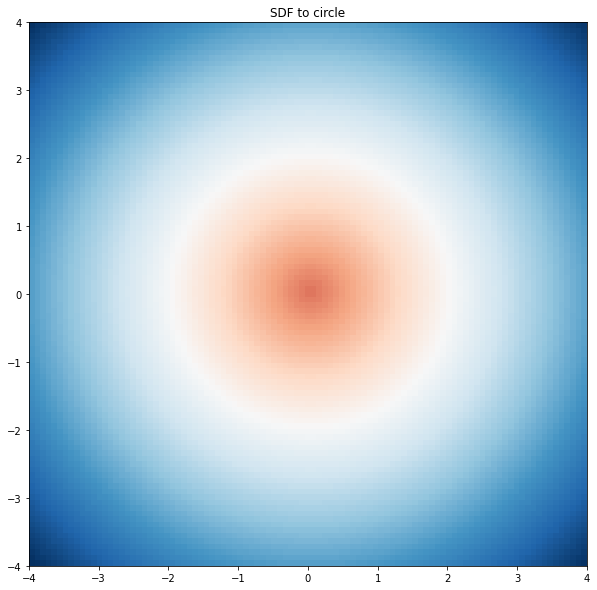

In [41]:
# circle: center(0,0) radius 2
circle = Circle(np.float_([0, 0]), 2)
plot_sdf(circle.sdf)
plt.title("SDF to circle")
plt.show()

In [42]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

net = Net()
print(net)


Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


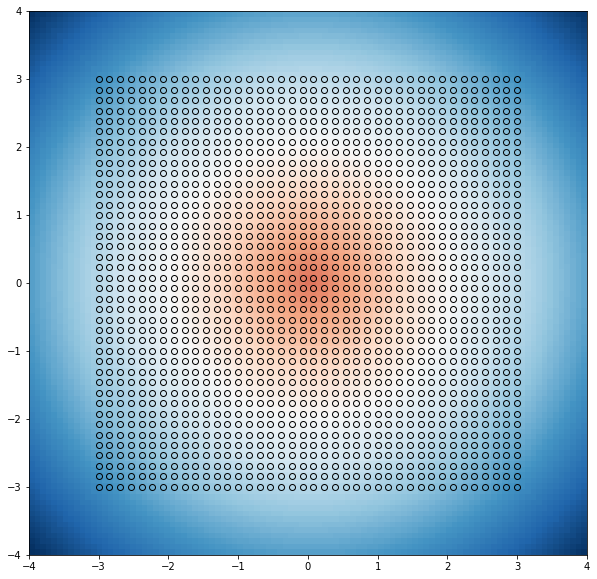

In [43]:
points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(circle.sdf, points_train)))

plot_sdf(circle.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

In [44]:
train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

/tmp/ipykernel_3237/3383290664.py:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  z = np.float_([[sdf_func(np.float_([x_, y_])).cpu().detach()
/tmp/ipykernel_3237/3383290664.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  z = np.float_([[sdf_func(np.float_([x_, y_])).cpu().detach()


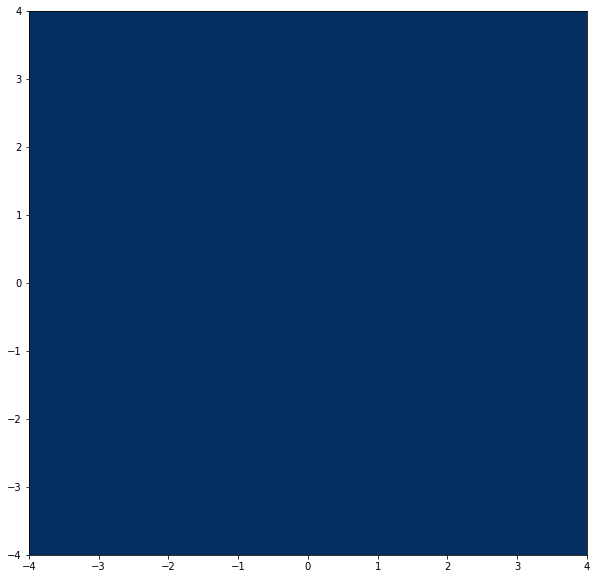

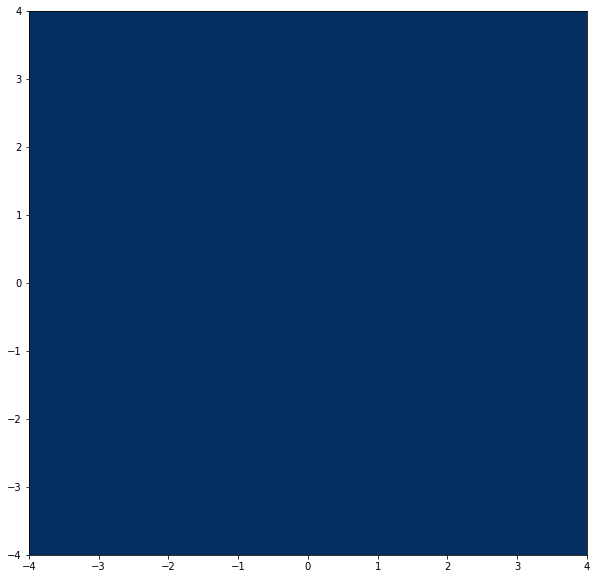

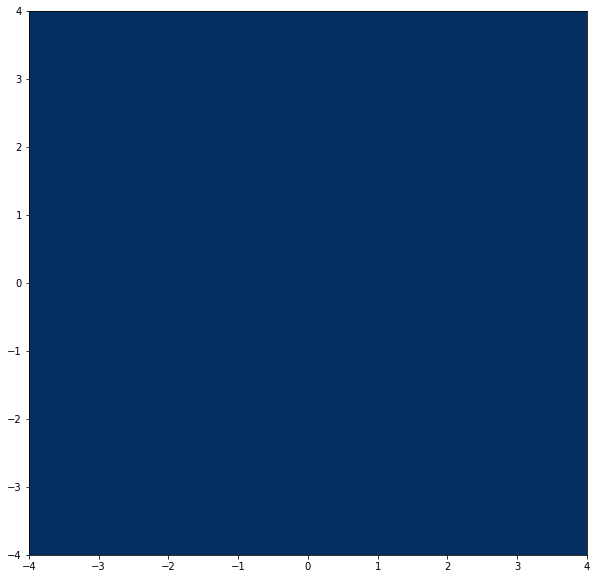

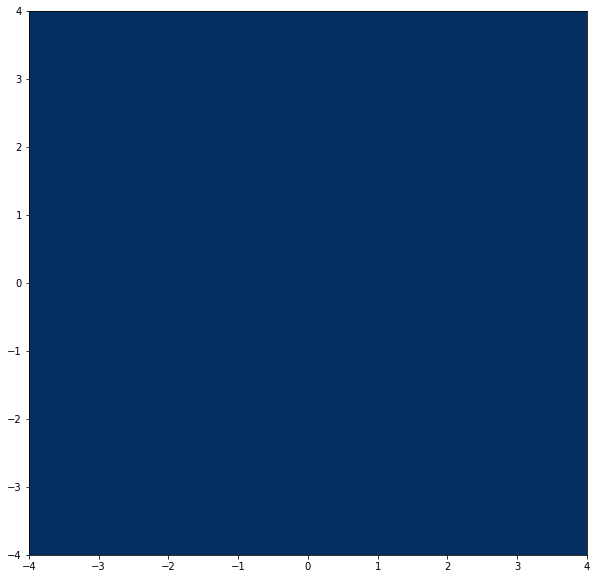

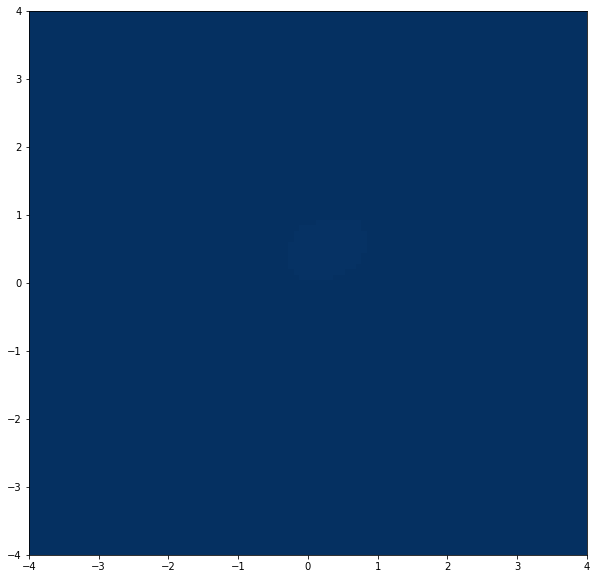

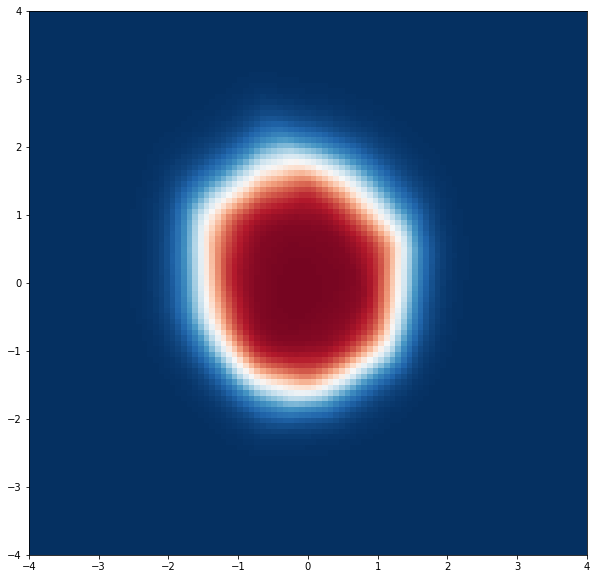

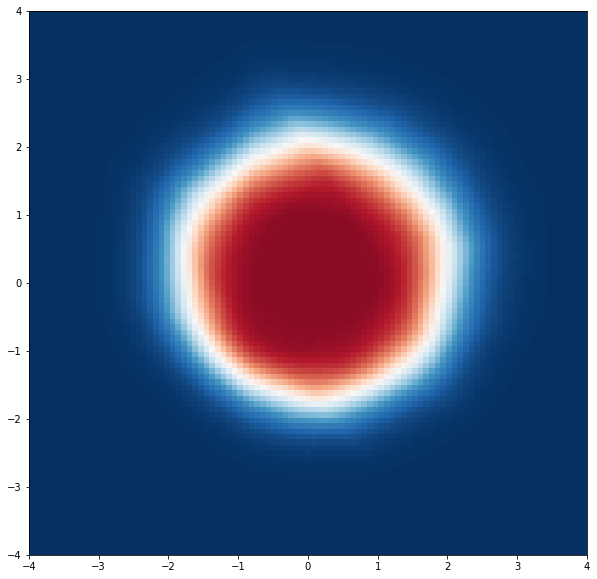

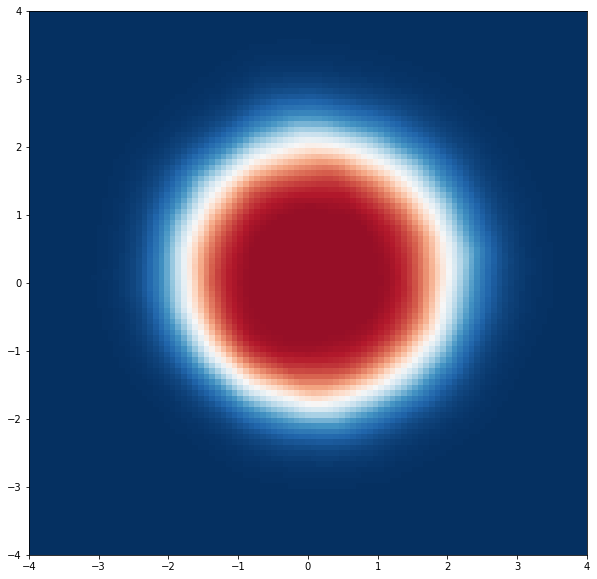

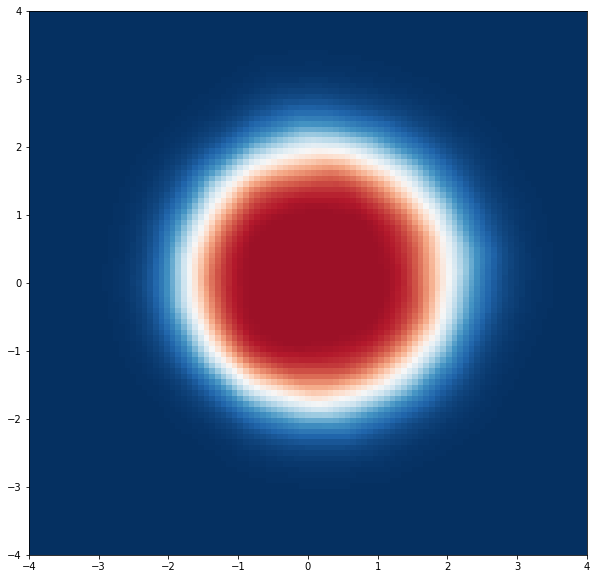

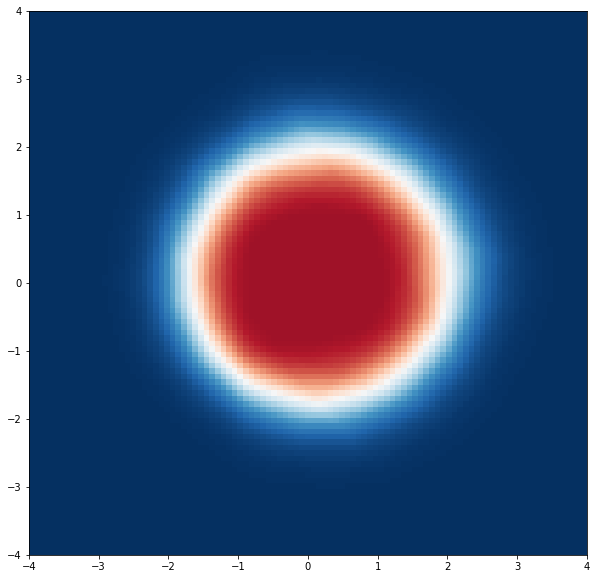

In [45]:
net = Net()
epochs = 1000
delta = 10
opt = optim.SGD(net.parameters(), lr=1)

for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    # print("Epoch:", epoch, "Loss:", total_loss.item())
    
    if (epoch % 100 == 0):
        plot_sdf(net.forward)
        plt.show()